Notes on study. When training the network for a combined three hours the apple and boundary combined with the old mutation rate standards did extremely poor at an astounding 120 fitness. The graph showed that it wouldn't improve any time soon. On the other hand, the just apple snakes managed to get over 260 fitness within the first half hour. It truly puzzles me why this happens. I will now try using the new mutation_rate method along with the apple and boundary snakes. Hopefully this works out better

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pygame
from pygame.locals import *
from random import randint
from sys import exit

pygame 2.0.1 (SDL 2.0.14, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class layer:
    """
    Creates class that holds value, bias, and weights of all neurons in layer. 
    Has additional variables: first_layer (bool) and size (int)
    """
    def __init__(self, size, weights, is_first_layer = False):
        """
        Creates layer object. If first_layer is true will not have bias and weights
        """
        self.size = size
        self.value = np.zeros(size)
        self.first_layer = is_first_layer
        
        if not self.first_layer:
            self.bias = np.random.rand(size)*2-np.ones(size)
            self.weights = weights 
            
    def mutate_by_rate(self, weights, mutation_rate, multiplier = 1.5):
        """
        Changes weights and biases of self
        """
        bias = np.random.randn(self.size)*multiplier
        layout = np.random.rand(self.size)
        layout2 = np.random.rand(self.size)
        bias[layout < mutation_rate/10] = 0
        self.bias += bias
        self.bias[layout2 < mutation_rate/100] *= -1
        self.weights += weights
        
        layout2 = np.random.rand(weights.shape[0], weights.shape[1])
        self.weights[layout2 < mutation_rate/100] *= -1
            
    def copy(self):
        """
        Returns copy of layer (same size, weights, bias, first_layer)
        """
        if self.first_layer:
            copycat = layer(self.size, 0, True)
            copycat.size = self.size
        else:
            copycat = layer(self.size, self.weights.copy())
            copycat.bias = self.bias.copy()
            
        return copycat
    
    def __eq__(self, other_layer):
        
        if self.size != other_layer.size:
            return False
        
        if self.first_layer == True or other_layer.first_layer == True:
            if self.first_layer == other_layer.first_layer:
                return True
            else:
                return False
            
        if not np.array_equal(self.bias, other_layer.bias):
            return False
        if not np.array_equal(self.weights, other_layer.weights):
            return False
        
        return True
    
class network:
    """
    Creates network to deal with layers. Has layers list and layers_tuple. 
    First object in layers is always layer with first_layer = True
    """
    def __init__(self, layers_tuple):
        """
        Create network object
        """
        self.layers = []
        self.layers_tuple = layers_tuple    
        
        first_time = True
        for size in layers_tuple:
            
            if first_time:
                self.layers.append(layer(size, 0, True))
                first_time = False
                continue
             
            self.layers.append(layer(size, np.random.rand(size, self.layers[-1].size)*2-np.ones((size, self.layers[-1].size))))
            
                
    def sigmoid(x):
        """
        Is function of class, returns sigmoid of value passed to it. Can take in array as well
        """
        sigm = 1 / (1 + np.exp(-x))
        return sigm 
        
    def calculate(self, input_array):
        """
        Returns output numpy array when given input numpy array
        """
        for index, layer in enumerate(self.layers):
            if layer.first_layer:
                layer.value = input_array
                continue
            
            layer.value = network.sigmoid(layer.bias + np.matmul(layer.weights, self.layers[index-1].value))
            
        return self.layers[-1].value.copy()

    def mutate_by_rate(self,mutation_rate=1.0, multiplier = 1.5):
        """
        PASS COPY OF SELF INTO METHOD
        """
        for index, layer in enumerate(self.layers):
            if layer.first_layer:
                continue 
            
            weights = np.random.randn(layer.size, self.layers[index-1].size)*multiplier
            layout = np.random.rand(layer.size, self.layers[index-1].size)
            weights[layout < mutation_rate/10] = 0
            layer.mutate_by_rate(weights, mutation_rate, multiplier)
    
    def mutate_by_crossover(self, oppurtunity):
        """
        Not yet made
        """
        
        pass
                    
    def copy(self):
        """
        Returns copy of network
        """
        copycat = network(self.layers_tuple)
        for index, layer in enumerate(self.layers):
            copycat.layers[index] = self.layers[index].copy()
            
        return copycat
    
    def __str__(self):
        
        first_time = True
        for layer in self.layers:
            if layer.first_layer:
                continue
            
            print("New Layer!")
            print(layer.weights)
            print(layer.bias)
        return ""
    
    def __eq__(self, other_network):
        if not self.layers_tuple == other_network.layers_tuple:
            return False
        for layer, other_layer in zip(self.layers, other_network.layers):
            if not layer == other_layer:
                return False 
            
        return True
    
    def save(self, filename = 'neural_network'):
        #need to save self.layers and self.layers_tuple
        with open(filename, mode='w')as f:
            #Save metadata
            f.write(str(self.layers_tuple)+"\n")
            
            #Save bias
            for layer in self.layers[1:]:
                f.write(str(layer.bias))
            f.write("\n")
            
            #Save Weights
            for layer in self.layers[1:]:
                f.write(str(layer.weights).replace("\n ", "")+"\n")
            
                
    
    def load(filename = 'neural_network'):
        try:
            with open(filename, mode='r') as f:

                file = f.read().split("\n")

                #Get the layer_tuple
                layers_tuple_string = file[0][1:-1].split(', ')
                layers_tuple = tuple([int(num) for num in layers_tuple_string])

                n = network(layers_tuple)

                #Get the biases
                bias_string = file[1][1:-1].split('][')

                for i in range(len(bias_string)):
                    all_nums = [el for el in bias_string[i][1:].split(' ') if el != ""]
                    all_nums = list(map(float, all_nums))
                    n.layers[i+1].bias = np.array(all_nums)

                #Get the weights
                for i in range(len(layers_tuple)-1):
                    weights_string = file[2+i][2:-2].split("][")

                    all_twodim_nums = []
                    for neuron_weights_string in weights_string:
                        all_onedim_nums = [el for el in neuron_weights_string.split(" ") if el != ""]
                        all_onedim_nums = list(map(float, all_onedim_nums))
                        all_twodim_nums.append(all_onedim_nums)
                    n.layers[1+i].weights = np.array(all_twodim_nums)

            return n
        
        except FileNotFoundError:
            return False
        
class population:
    """
    Is front of AI operations. Handles all work and uses network and layer classes for own purposes.
    Game class should only have to call methods off of this class. 
    Game class should store: pop (population); fitness (array 1 dim); input (array 2 dim)
    Game class should handle: output (array 2 dim)
    """
    def __init__(self, population_size, network_layers_tuple):
        """
        Create list of networks stored as residents (list); network_size (tuple) stores network layers_tuple.
        population_size stores number of residents and fitness stores fitness scores
        """
        self.network_size = network_layers_tuple
        self.fitness = np.zeros(population_size)
        self.population_size = population_size
        self.residents = [network(network_layers_tuple) for i in range(population_size)]
        
    def calculate(self, input_array):
        """
        Take in input 2d array. (format: array([first network inputs], [second network inputs], ...))
        Return output 2d array. (format: array([first network output], [second network output], ...))
        """
        output_array = np.zeros((self.population_size, self.network_size[-1]))
        
        for index, network in enumerate(self.residents):
            output_array[index] = network.calculate(input_array[index])
               
        return output_array
    
    def set_fitness(self, fitness_array):
        self.fitness = fitness_array
        self.fitness[self.fitness<0] = 0
  
    
    def copy(self):
        """
        Returns copy of self
        """
        copycat = population(self.population_size, self.network_size)
        for index, resident in enumerate(self.residents):
            copycat.residents[index] = resident.copy()
            
        return copycat
    
    def mutate_by_best(self, mutation_rate = 1):
        """
        Input mutation_rate to specify how much top network should change
        Takes best and mutates it while adding in a population_size/6 randomly generated networks.
        """
        top_network = self.residents[self.fitness.argmax()]
        self.residents = []
        number_random = int(np.floor(np.array([self.population_size])/50))
        
        self.residents.append(top_network.copy())
        for i in range(number_random):
            self.residents.append(network(self.network_size))
                            
        for i in range(self.population_size - number_random-1):
            top_net_copy = top_network.copy()
            top_net_copy.mutate_by_rate(mutation_rate)
            self.residents.append(top_net_copy)
        
        self.fitness = np.zeros(self.population_size)
    
    def mutate_by_fitness(self, mutation_rate=1):
        for el in self.fitness:
            if el < 0:
                raise ValueError("Wtf: ", self.fitness)
        """
        Input mutation_rate to specify how much selected network should change
        Adds population_size/6 random networks and then mutates network that is selected from self.residents
        However networks with higher fitness have greater chance of getting selected 
        """
        number_random = int(np.floor(np.array([self.population_size])/50))
        new_residents = []
        new_residents.append(self.residents[self.fitness.argmax()])
        
        for i in range(number_random):
            new_residents.append(network(self.network_size))
        
        for i in range(self.population_size - number_random - 1):
            
            total = np.random.rand(1)*np.sum(self.fitness)
            
            selected_index = "False"
            
            for i in range(len(self.fitness)):
                if np.sum(self.fitness[:i+1]) > total:
                    selected_index = i 
                    break
            
            try:
                selected_net = self.residents[selected_index].copy()
            except:
                raise ValueError("asd;fjahsldkjfha: ", self.fitness, total, selected_index)
            selected_net.mutate_by_rate(mutation_rate)
            new_residents.append(selected_net)
        
        self.residents = new_residents
        
        
    def mutate_by_crossover(self):
        pass
                

In [3]:
n = network((6,4))
print(n)
n.mutate_by_rate()
print(n)

New Layer!
[[ 0.77824921  0.06231661  0.41758303  0.17531388  0.17364359 -0.60850916]
 [-0.74712679  0.09943623  0.01791125  0.01861166  0.59617316 -0.2580415 ]
 [ 0.85248488 -0.95394807 -0.01237337  0.58695352  0.24018783  0.1653096 ]
 [-0.14734808 -0.28484733  0.24335452 -0.06785158  0.53600527 -0.61572866]]
[-0.48618066 -0.8924637   0.07452967 -0.82651416]

New Layer!
[[ 2.19482832  0.52252999  0.21503548  0.17531388  0.67456233  0.55768854]
 [-2.27105508  0.25840888  1.59271295  1.29635935  0.84776162 -0.92086023]
 [ 0.65717424 -0.95394807 -2.12909621  2.29713905 -0.72060261 -0.73377559]
 [-0.97121013 -0.16379287  1.03786007  1.24231773 -0.72599     0.29434124]]
[-2.61872409 -1.81743034  0.29572464 -0.37237385]



So it has been a super looooooong time since I have touched Python and I decided to come back into by working on snake again. This time however, I actually want the snake to do good. I added the visualize snake function which you test up there. I wonder if having this will make things more clear. Anyway, I will also remake the snake game to warm myself up. Here we go!

In [3]:
class snake:
    def __init__(self, cellsize=20, game_length = 600, game_width = 600):
        #Essentials (body order: [tail, middle, front])
        self.body = [pygame.Rect(60, 300, cellsize, cellsize), pygame.Rect(80, 300, cellsize, cellsize)]
        
        #Interacting Objects 
        self.apple = apple(cellsize, game_length, game_width)
        
        #Constants
        self.cellsize = cellsize
        self.RIGHT, self.LEFT = pygame.math.Vector2(cellsize,0), pygame.math.Vector2(-cellsize,0)
        self.UP, self.DOWN = pygame.math.Vector2(0,-cellsize), pygame.math.Vector2(0,cellsize)
        self.game_length, self.game_width = game_length, game_width
        
        #Control Variables
        self.moves_left = 50
        self.free_moves = 5
        self.fitness = 0
        self.moves_made = 0
        
        #Variables
        self.move = self.RIGHT
        self.alive = True
    
    def reset(self):
        self.body = [pygame.Rect(60, 300, self.cellsize, self.cellsize), pygame.Rect(80, 300, self.cellsize, self.cellsize)]
        self.move = self.RIGHT
        self.alive = True
        self.apple = apple(self.cellsize, self.game_length, self.game_width)
        self.move = self.RIGHT
        self.fitness = 0
        self.moves_left = 50
        self.moves_made = 0
        self.free_moves = 5
    
    def dist(self):
        return round((160-abs(self.body[-1].centerx - self.apple.body.centerx)-abs(self.body[-1].centery - self.apple.body.centery))/200, 1)
    
    def check_dead(self):
        head = self.body[-1]
        xpos, ypos = head.center
        #Check boundaries
        if xpos < 0 or ypos < 0 or xpos > self.game_length or ypos > self.game_width:
            self.alive=False
            self.change_control_on_death()
            return True
        
        #Check self
        if len(self.body) > 2:
            for rect in self.body[:-2]:
                if head.colliderect(rect):
                    self.alive=False
                    self.change_control_on_death()
                    return True
                
        #Check control variables
        if self.moves_left < 0:
            self.fitness *= 0.5
            self.alive = False
            self.change_control_on_death()
            return True
        
        return False
    
    def change_control_on_death(self):
        if self.moves_made > 30:
            self.fitness += (self.moves_made-30)/10
        
    def check_apple(self):
        #Change non-control variables
        if self.body[-1].colliderect(self.apple.body):
            tail = self.body[0]
            near_tail = self.body[1]
            self.body.insert(0, pygame.Rect(2*tail.left-near_tail.left, 2*tail.top-near_tail.top, self.cellsize, self.cellsize))
            
            self.apple.respawn(self.body)
            
            #Change control variables
            self.fitness += 40
            self.moves_left += 30
            self.free_moves += 5
            
    def update(self):
        #Change non-control variables
        tail_rect = self.body.pop(0)
        head_rect = self.body[-1]
        xpos, ypos = head_rect.centerx + self.move[0], head_rect.centery + self.move[1]
        tail_rect.center = (xpos, ypos)
        self.body.append(tail_rect)
        
        #Change control variables
        self.moves_left -= 1
        self.moves_made += 1
        if self.free_moves > 0:
            self.free_moves -= 1
        else:
            self.fitness += self.dist()    
    
    def show(self, gameDisplay):
        for rect in self.body:
            pygame.draw.rect(gameDisplay, (0,255,0), rect)
            pygame.draw.rect(gameDisplay, (4,155,70), rect, 2)
        self.apple.show(gameDisplay)
    
    def set_movement(self, option):
        """
        0 = Right   1 = Left    2 = Up    3 = Down
        """
        if option == 0:
            potential = self.RIGHT
        elif option == 1:
            potential = self.LEFT
        elif option == 2:
            potential = self.UP
        else:
            potential = self.DOWN        

        if potential*-1 != self.move:
            self.move = potential
        
    def network_input_just_apple(self):
        xdist = self.body[-1].centerx - self.apple.body.centerx
        ydist = self.body[-1].centery - self.apple.body.centery
        return np.array([xdist/600, ydist/600])
        
    def network_input_apple_and_boundary(self):
        xpos = self.body[-1].centerx
        ypos = self.body[-1].centery
        xdist = xpos - self.apple.body.centerx
        ydist = ypos - self.apple.body.centery
        xdif = self.game_length - xpos
        ydif = self.game_width - ypos
        return np.array([xdist, ydist, xpos, ypos, xdif, ydif])/600
        
    def network_input(self, option):
        """
        0 => just apple;  1 => apple and boundary
        """
        if option == 0:
            return self.network_input_just_apple()
        if option == 1:
            return self.network_input_apple_and_boundary()
        
class apple:
    
    def __init__(self, cellsize, game_length, game_width):
        self.body = pygame.Rect(200, 300, cellsize, cellsize)
        self.all_pos = [pygame.Rect(x,y, cellsize, cellsize) for x in range(0,game_length,20) for y in range(0,game_width,20)]
    
    def respawn(self, snake_body):
        all_squares = list(self.all_pos)
        for rect in snake_body:
            try:
                all_squares.pop(all_squares.index(rect))
            except:
                pass
        self.body = all_squares[randint(0, len(all_squares)-1)]
    
    def show(self, gameDisplay):
        pygame.draw.rect(gameDisplay, (255,0,0), self.body)
            
        

In [4]:
class OtherFunctions:
    
    def load_network(gameDisplay, pop):
        gameDisplay.fill((0,0,0))
        OtherFunctions.show_text(gameDisplay, "Visit the notebook!",(500,300))
        pygame.display.update()
        filename = input("Please type in the filename of the network you want to load:\n")
        
        temp = network.load(filename)
        while not temp:
            filename = input("That file does not exist. Please type a valid filename or press n to exit:\n")
            
            if filename == 'n':
                    gameDisplay.fill((0,0,0))
                    OtherFunctions.show_text(gameDisplay, "Seems no loading after all!", (500,300))
                    pygame.display.update()
                    pygame.time.wait(4000)
                    gameDisplay.fill((0,0,0))
                    return False
                
            temp = network.load(filename)
            
        pop.residents[-1] = temp
        gameDisplay.fill((0,0,0))
        OtherFunctions.show_text(gameDisplay, "It has been succesfully added to the population!", (500,300))
        pygame.display.update()
        pygame.time.wait(4000)
        gameDisplay.fill((0,0,0))
        return True
    
    def show_text(gameDisplay, text, loc, font = 'arial', size = 50, color = (255,255,255)):
        text_font = pygame.font.SysFont(font, size)
        textDisplaySurface = text_font.render(text, True, color)
        text_rect = textDisplaySurface.get_rect()
        text_rect.center = loc
        gameDisplay.blit(textDisplaySurface, text_rect)
        
    def show_stats(gameDisplay, x, fitness, generation, num_moves_left):
        OtherFunctions.show_text(gameDisplay, "The snake fitness is: " + str(round(fitness,2)), (x,25), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "This is generation: " + str(generation), (x,75), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "It has " + str(num_moves_left) + " moves left", (x,125), size=25, color = (0,0,255))

    def show_directions_in_view_screen(gameDisplay, x, ystart):
        OtherFunctions.show_text(gameDisplay, "Press p to pause the recording", (x,ystart), size=12, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "Press space to go back to home", (x,ystart+25), size=12, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "Press s to save this network. Once pressed, visit the notebook", (x,ystart+50), size=12, color = (0,0,255))
    
    def show_directions_in_home_screen(gameDisplay, generation, fitness):
        OtherFunctions.show_text(gameDisplay, "Welcome to snake!", (500,50), color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "Press v to view the best snake in this generation", (500,250), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "Press c to start calculating some new generations", (500,275), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "Press e to quit", (500,300), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "Press l to load a network", (500,325), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "The best snake fitness is: " + str(fitness), (500,425), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "This is generation: " + str(generation), (500,450), size=25, color = (0,0,255))
        
    def show_directions_in_calculate_screen(gameDisplay):
        OtherFunctions.show_text(gameDisplay, "Training Time!", (500,50), color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "Press space to quit", (500,175), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "Press p to continue. Once pressed, check the notebook", (500,200), size=25, color = (0,0,255))

    def show_secret(gameDisplay, generations_complete, fitness):
        OtherFunctions.show_text(gameDisplay, "You have started the hidden process of training forever.", (500,225), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "Of course you can always press space to exit.", (500,250), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "So far " + str(generations_complete) + " have been completed.", (500,275), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "The best fitness is: " + str(fitness), (500,305), size=25, color = (0,0,255))
    
    def show_progress(generations_to_skip, percent_complete, fitness):
        OtherFunctions.show_text(gameDisplay, "We recieved: " + str(generations_to_skip) + " generations", (500,225), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "The best fitness is: " + str(fitness), (500,250), size=25, color = (0,0,255))
        OtherFunctions.show_text(gameDisplay, "Progress on calculating: " + str(percent_complete) + "%", (500,275), size=25, color = (0,0,255))
        pygame.draw.rect(gameDisplay, (0,255,0), pygame.Rect(450,320,percent_complete,10))                                     
        pygame.draw.rect(gameDisplay, (128,128,128), pygame.Rect(450,320,100,10), 2)
                                     
    def show_neural_net(gameDisplay, network, length = 1000, width=600, topx = 0, topy = 0):
        """
        will draw network. Draws net by drawing layer then drawing connection to previous layer
        """
        
        #Define Important Variables
        max_neurons_in_layer = max(network.layers_tuple)
        radius = int((width/(max_neurons_in_layer*2+3))/2) #is distance between neurons
        layer_dist = int((length-radius*2*len(network.layers_tuple)-50)/(len(network.layers_tuple)-1))
        x = radius*3
        
        #Iterate through neurons
        for i in range(len(network.layers)):
            layer = network.layers[i]
            layerbefore = network.layers[i-1]
            num_previous = layerbefore.size
            
            y = int(width/2 - (layer.size-1)*radius*2) 
            if y<0: raise ValueError("y value is negative!", y) 
            
            #Iterate through neurons
            for k in range(layer.size): 
                val = layer.value[k]
                
                #Draw Connections if not the first layer
                if i>0:
                    py = int(width/2 - (num_previous-1)*radius*2)
                    for j in range(num_previous):
                        
                        w = layer.weights[k][j]
                        
                        if w>1:
                            w = 1
                        elif w < -1:
                            w = -1
                            
                        if w>0:
                            c2 = int(255*w)
                            pygame.draw.line(gameDisplay, (0,0,c2), (topx+x-layer_dist, topy+py), (topx+x, topy+y), 1)
                        else:
                            c2 = int(-255*w)
                            pygame.draw.line(gameDisplay, (c2,0,0), (topx+x-layer_dist, topy+py), (topx+x, topy+y), 1)
                        py+=4*radius
                
                #Draw dots for layer
                if i == 0:
                    if val < 0:
                        c = int(val*-255)
                        pygame.draw.circle(gameDisplay, (c,c,c), (topx+x, topy+y), radius)
                    else:
                        c = int(val*255)
                        pygame.draw.circle(gameDisplay, (c,c,c), (topx+x, topy+y), radius)
                    
                else:
                    if val > 1: raise ValueError("val is greater than 1 (activation function must map to (0,1))", val)
                    if val < 0: raise ValueError("val is less than 0 (activation function must map to (0,1))", val)
                    c = int(val*255)
                    loc = (topx+x, topy+y)
                    pygame.draw.circle(gameDisplay, (c,c,c), loc, radius)
                    
                    #Draw bias
                    b = layer.bias[k]
                    if b < 0:
                        OtherFunctions.show_text(gameDisplay, str(round(b,2)), loc, size=10, color = (255,0,0))
                    else:
                        OtherFunctions.show_text(gameDisplay, str(round(b,2)), loc, size=10, color = (0,0,255))
                    
                        
                y+=4*radius
                
            x += layer_dist

            
        

In [5]:
def show_network(gameDisplay, n, generation, option):

    s = snake()
    
    cont = True
    run = True
    while run:

        #Interaction
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                exit()

            if event.type == KEYDOWN:
                if event.key == pygame.K_SPACE:
                    run = False

                elif event.key == pygame.K_p:
                    if cont:
                        OtherFunctions.show_text(gameDisplay, "Paused", (300,300))
                        pygame.display.update()
                        cont = False
                    else:
                        cont = True
                elif event.key == pygame.K_s:
                    gameDisplay.fill((0,0,0))
                    OtherFunctions.show_text(gameDisplay, "Visit the notebook!",(500,300))
                    pygame.display.update()
                    filename = input("Please enter the filename you want to save it to:\n")
                    n.save(filename)

        choice = n.calculate(s.network_input(option))

        s.set_movement(choice.argmax())

        if not cont:
            continue
            
        s.update()
            
        if s.check_dead():
            gameDisplay.fill((0,0,0))
        
            OtherFunctions.show_stats(gameDisplay, 800, s.fitness, generation, s.moves_left)
      
            OtherFunctions.show_text(gameDisplay, "It died!", (300,300))
            pygame.display.update()
            pygame.time.wait(2000)
    
            s.reset()
            
        s.check_apple()
        
        gameDisplay.fill((0,0,0))
        
        s.show(gameDisplay) 
        
        pygame.draw.line(gameDisplay, (255,255,255), (600, 0), (600, 600))

        OtherFunctions.show_stats(gameDisplay, 800, s.fitness, generation, s.moves_left)
        OtherFunctions.show_directions_in_view_screen(gameDisplay, 800, 175)
        OtherFunctions.show_neural_net(gameDisplay,n,length=400, width=400, topx=600,topy=200) 

        pygame.display.update()
        pygame.time.wait(100)
        
    gameDisplay.fill((0,0,0))



In [6]:
def calculate_population(gameDisplay, pop, generation, option):
    done = False
    typed = False
    forever = False
    generations_complete = 0
    new_data = []
    while not done:
        
        for event in pygame.event.get():
            if event.type == QUIT: 
                pygame.quit()
                exit() 
            
            elif event.type == KEYDOWN:
                if event.key == pygame.K_SPACE:
                    done = True
                    
                if event.key == pygame.K_p:
                    typed = True
                    generations_to_skip = int(input("Please enter how many generations you want to skip:\n"))
                    print("Further information will be available back at the program!\n")
                
                if event.key == pygame.K_f:
                    forever = True       
        
        gameDisplay.fill((0,0,0))
        OtherFunctions.show_directions_in_calculate_screen(gameDisplay)
        
        if typed:
            pop = train_population(pop, option)
            
            new_data.append((generation+generations_complete, pop.fitness.max()))
            generations_complete += 1
            percent_done = int(100*generations_complete/generations_to_skip)
    
            OtherFunctions.show_progress(generations_to_skip, percent_done, pop.fitness.max())
            
            if generations_complete >= generations_to_skip:
                done = True
                
        elif forever:
            pop = train_population(pop, option)
            new_data.append((generation+generations_complete, pop.fitness.max()))
            generations_complete += 1 
            
            OtherFunctions.show_secret(gameDisplay, generations_complete, pop.fitness.max())
    
        pygame.display.update()
        
    gameDisplay.fill((0,0,0))

    return pop.residents[pop.fitness.argmax()].copy(), generation + generations_complete, new_data

def train_population(pop, option, iterations = 50):
    
    fitness = np.zeros(pop.population_size)
    
    for _ in range(iterations):
        
        num_left = pop.population_size
        all_snakes = [snake() for i in range(num_left)]

        
        while num_left>0:

            for i in range(pop.population_size):

                s = all_snakes[i]
                if s.alive:

                    choice = pop.residents[i].calculate(s.network_input(option))
                    s.set_movement(choice.argmax())

                    s.update()

                    if s.check_dead():
                        num_left -= 1
                        fitness[i] += s.fitness
                        continue

                    s.check_apple()
            

    pop.set_fitness(fitness/iterations)
    pop.mutate_by_fitness(2)
    return pop

In [7]:
pygame.init()
pygame.display.set_caption("Snake")
gameDisplay = pygame.display.set_mode((1000,600))

option = 0

if option == 0:
    snakes = population(500, (2,4))
    best_network = network((2,4))
if option == 1:
    snakes = population(1000, (6,4))
    best_network = network((6,4))
    
generation = 0
fitness = 0
data = []


run = True
while run: 
    
    for event in pygame.event.get():
        if event.type == QUIT:
            run = False
        
        elif event.type == KEYDOWN:  
            if event.key == K_e:
                run = False
            elif event.key == K_v:
                show_network(gameDisplay, best_network, generation, option) 
            elif event.key == K_c:
                best_network, generation, new_data = calculate_population(gameDisplay, snakes, generation, option)
                fitness = snakes.fitness.max()
                for el in new_data:
                    data.append(el)
                
            elif event.key == K_l:
                if OtherFunctions.load_network(gameDisplay, snakes):
                    best_network = snakes.residents[-1]
                    
    OtherFunctions.show_directions_in_home_screen(gameDisplay, generation, fitness)        
    pygame.display.update()
       


pygame.quit()

Text(0.5, 1.0, 'Network fitness over generations')

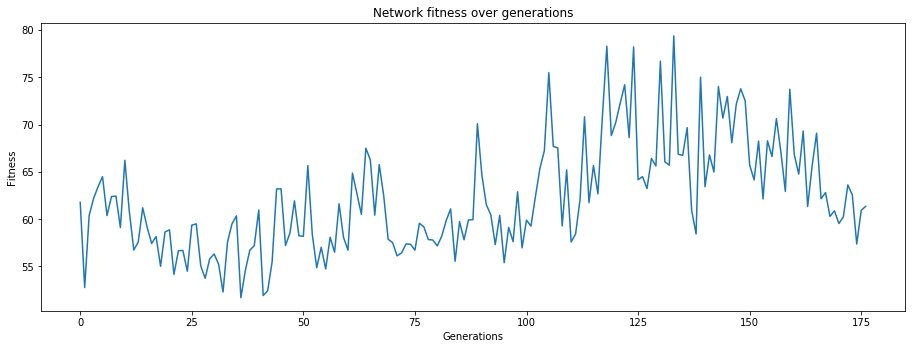

In [30]:
gen, fit = zip(*data)
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2.0,1.0])
axes.plot(gen, fit)
axes.set_xlabel('Generations')
axes.set_ylabel('Fitness')
axes.set_title("Network fitness over generations")

Text(0.5, 1.0, 'Network fitness over generations')

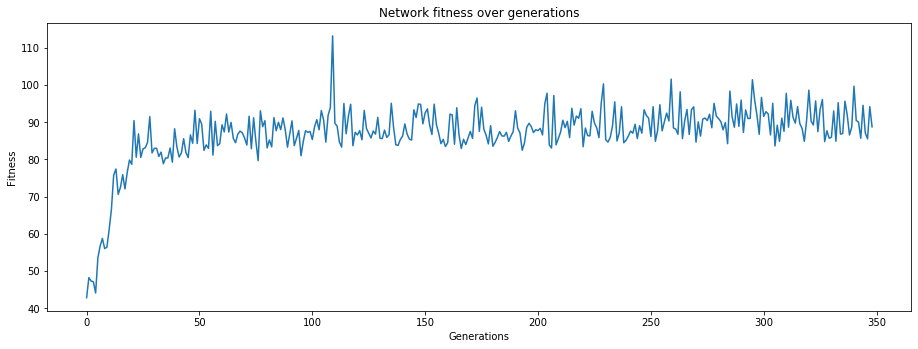

In [21]:
gen, fit = zip(*data)
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2.0,1.0])
axes.plot(gen, fit)
axes.set_xlabel('Generations')
axes.set_ylabel('Fitness')
axes.set_title("Network fitness over generations")